In [1]:
import numpy as np

Source : https://realpython.com/numpy-array-programming/#image-feature-extraction

# Vectorization and Broadcasting

In [2]:
# 3-d array with 36 elements
# three 4x3 grids
arr = np.arange(36).reshape(3, 4, 3)

In [3]:
arr

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]],

       [[24, 25, 26],
        [27, 28, 29],
        [30, 31, 32],
        [33, 34, 35]]])

__Vectorization__ : operations occurring on entire arrays (array expressions), as opposed to individuals elements; Vectorized operations in NumPy delegate the looping internally to highly optimized C and Fortran functions

## Example : "False to True" Transitions

In [4]:
np.random.seed(444)

x = np.random.choice([False, True], size=1000000)

In [5]:
# first method - explicit
# counts the number of “False to True” transitions in the sequence:
def count_transitions(arr_x):
    counter = 0
    for i in range(len(arr_x) - 1):
        if arr_x[i] == False and arr_x[i+1] == True:
            counter += 1
            continue
        if i == len(arr_x) - 1:
            return counter
    return counter

In [6]:
# second method : implicit and using zip
def count_transitions_implicit(x):
    count = 0
    for i,j in zip(x[:-1], x[1:]):
        if not i and j:
            count += 1
    return count

In [7]:
%time count_transitions_implicit(x)

Wall time: 116 ms


250328

In [8]:
%time count_transitions(x)

Wall time: 1.61 s


250328

In [9]:
# third method : vectorized form
%time np.count_nonzero(x[:-1] < x[1:])

Wall time: 3.99 ms


250328

## Example : Buy Low, Sell High

In [10]:
# Given a stock’s price history as a sequence
# and assuming that you are only allowed to make one purchase
# and one sale, returns the maximum profit that can be obtained

# this solution has n-squared time complexity
def profit(sequence):
    cur_profit = 0
    min_buy = 0
    max_sell = 0
    for buy in range(len(sequence) - 1):
        for sell in range(buy + 1, len(sequence)):
            if sequence[sell] - sequence[buy] > cur_profit:
                min_buy = buy
                max_sell = sell
            cur_profit = max(sequence[sell] - sequence[buy], 
                             cur_profit)
    return (min_buy, max_sell, cur_profit)

In [11]:
# buy at 15, sell at 150
stock_hist = [25, 75, 100, 125, 15, 55, 150, 6]
%time profit(stock_hist)

Wall time: 0 ns


(4, 6, 135)

In [12]:
# this solution has linear time complexity
def linear_profit(sequence):
    cur_largest_profit = 0
    min_price = sequence[0]
    for val in sequence[1:]:
        
        # the smallest price we've seen thus far
        min_price = min(min_price, val)
        
        # the current largest profit
        # will be either the current value - smallest price seen
        # or the current largest profit
        cur_largest_profit = max(val - min_price, 
                                 cur_largest_profit)
    return cur_largest_profit

In [13]:
%time linear_profit(stock_hist)

Wall time: 0 ns


135

In [14]:
# creates a NaN array of size 100
prices = np.full(100, fill_value=np.nan)

# inserts "turning points" at different locations
prices[[0, 25, 60, -1]] = [80., 30., 75., 50.]

In [15]:
x = np.arange(len(prices))

In [16]:
is_valid = ~np.isnan(prices)

__Interpolation__ - a method of constructing _new data points_ within the _given range_ of a discrete set of _known data points_.

In [17]:
# linearly interpolate the missing values
prices = np.interp(x=x, xp = x[is_valid], fp = prices[is_valid])

In [18]:
# adding some noise
prices += np.random.randn(len(prices)) * 2

In [19]:
import matplotlib.pyplot as plt

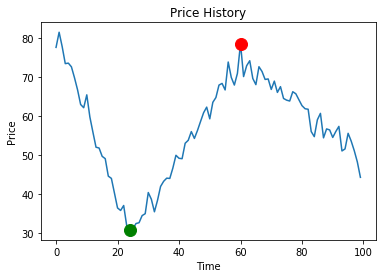

In [20]:
mn = profit(prices)[0]
mx = profit(prices)[1]

fig, ax = plt.subplots()
ax.plot(prices)
ax.set_title('Price History')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.plot(mn, prices[mn], color='green', markersize=12, marker='o')
ax.plot(mx, prices[mx], color='red', markersize=12, marker='o')

In [21]:
# we'll use this to find the difference between each price
# and a running minimum
cummin = np.minimum.accumulate

# this has linear time complexity
def profit_with_numpy(prices):
    """Price minus cumulative minimum price, element-wise"""
    prices = np.asarray(prices)
    return np.max(prices - cummin(prices))

In [22]:
profit_with_numpy(prices)

47.613810591393445

Let's look at runtimes.

In [23]:
seq = np.random.randint(0,100, size=2000)

In [24]:
%time profit(seq)

Wall time: 1.96 s


(162, 205, 99)

In [25]:
%time profit_with_numpy(seq)

Wall time: 2.99 ms


99

### Understanding Axes Notation

numpy axis - a single dimension of a multi-dimensional array; refers to the axis _along which_ a function gets called; specifies the dimension of the array that will be collapsed

In [26]:
arr = np.array([[1,2,3], [10,20,30]])

# will collapse the rows by performing a column-wise computation
arr.sum(axis=0)

array([11, 22, 33])

In [27]:
arr.sum(axis=1)

array([ 6, 60])

## Broadcasting

In [28]:
a = np.array([1.5,2.5,3.5])
b = np.array([10.,5.,1.])

In [29]:
a/b

array([0.15, 0.5 , 3.5 ])

__Broadcasting__ - describes how NumPy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is "broadcast" across the larger array so that they have compatible shapes.

Rules for Broadcasting with Two Arrays
Compatible when:
 - they are equal, or
 - one of them is 1

In [30]:
# loc - mean
# scale - standard deviation
sample = np.random.normal(loc = [2., 20.],
                         scale = [1., 3.5],
                         size = (3,2))
sample

array([[ 0.32188688, 20.22258919],
       [ 1.29119813, 23.11756446],
       [ 2.50471167, 19.82079232]])

In [31]:
mu = sample.mean(axis = 0);
mu

array([ 1.37259889, 21.05364866])

In [32]:
# subtrating by the mean, column-wise
# even though the arrays are not the same size,
# mu is "stretched" such that its mean values repeat
# This is a case where the smaller array is
# broadcast across the larger array so they have
# compatible shapes
sample - mu

array([[-1.05071202, -0.83105946],
       [-0.08140076,  2.0639158 ],
       [ 1.13211277, -1.23285634]])

In [33]:
# standardizing each column uses broadcasting
(sample - sample.mean(axis=0)) / sample.std(axis=0)

array([[-1.17662047, -0.56588616],
       [-0.09115514,  1.40536441],
       [ 1.26777561, -0.83947825]])

Let's try to subtract the row-wise minimums

In [34]:
sample

array([[ 0.32188688, 20.22258919],
       [ 1.29119813, 23.11756446],
       [ 2.50471167, 19.82079232]])

In [35]:
# shape (3,)
sample.min(axis=1)

array([0.32188688, 1.29119813, 2.50471167])

In [39]:
# sample - sample.min(axis=1)

In [40]:
# [:, None] is a means by which to expand the
# dimensionality of an array

In [41]:
# 3 minimums across three rows
# shape = (3,1) as opposed to (3,)
sample.min(axis=1)[:, None]

array([[0.32188688],
       [1.29119813],
       [2.50471167]])

In [42]:
sample - sample.min(axis=1)[:, None]

array([[ 0.        , 19.90070232],
       [ 0.        , 21.82636632],
       [ 0.        , 17.31608065]])

Rule for Broadcasting Arbitrary Number of Arrays:
1. The arrays all have exactly the same shape
2. The arrays all have the same number of dimensions, and the length of each dimension is either a common length or 1.
3. The arrays that have too few dimensions can have their NumPy shapes prepended with a dimension of length 1 to satisfy property #2

Example

In [43]:
# four arrays
a = np.sin(np.arange(10))[:, None]
b = np.random.randn(1,10)
c = np.full_like(a, 10)
d = 8

In [44]:
# before checking shapes, NumPy first converts
# scalars to arrays with one element
arrays = [np.atleast_1d(arr) for arr in (a,b,c,d)]

In [45]:
for arr in arrays:
    print(arr.shape)

(10, 1)
(1, 10)
(10, 1)
(1,)


In [46]:
# check criterion #1
# if all the arrays have the same shape,
# the set of their shapes would have length=1
len(set(arr.shape for arr in arrays)) == 1

False

In [47]:
# check criterion #2
len(set(arr.ndim for arr in arrays)) == 1

False

In [48]:
# check criterion #3

# maximum dimension
maxdim = max(arr.ndim for arr in arrays)
shapes = np.array([(1,) * (maxdim - arr.ndim) + arr.shape
                   for arr in arrays])

In [49]:
shapes

array([[10,  1],
       [ 1, 10],
       [10,  1],
       [ 1,  1]])

In [50]:
# test the length of each dimension is either 
# (drawn from) a common length, or 1
masked = np.ma.masked_where(shapes == 1, shapes)

In [51]:
np.ptp(masked.ptp(axis=0) == 0)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [52]:
# check if the peak-to-peak (np.ptp()) column-wise
# differences are all zeros

# ptp : max - min
np.all(masked.ptp(axis=0) == 0)

True

In [53]:
# an argument with single asterisk prefixed 
# to it helps in receiving variable number of 
# arguments from calling environment

# let's encapsulate the above into a single function
def can_broadcast(*arrays):
    arrays = [np.atleast_1d(arr) for arr in arrays]
    if len(set(arr.shape for arr in arrays)) == 1:
        return True
    if len(set(arr.ndim for arr in arrays)) == 1:
        return True
    maxdim = max(arr.ndim for arr in arrays)
    
    # we want to get the new shapes for each of the arrays
    # we standardize the array shapes, so they're compatible
    # to fit with the array with the largest number of dimensions
    shapes = np.array([(1,) * (maxdim - arr.ndim) + arr.shape
                      for arr in arrays])
    masked = np.ma.masked_where(shapes == 1, shapes)
    return np.all(masked.ptp(axis=0) == 0)

In [54]:
can_broadcast(a,b,c,d)

True

In [55]:
def can_broadcast(*arrays):
    try:
        np.broadcast(*arrays)
        return True
    except ValueError:
        return False

In [56]:
can_broadcast(a,b,c,d)

True

## Array Programming in Action: Examples

### Clustering Algorithms

ML takes advantage of vectorization and broadcasting. Let's say you have the vertices of a triangle (each row is an x, y coordinate).

In [58]:
tri = np.array([
    [1,1],
    [3,1],
    [2,3]
])

The centroid of this "cluster" is an (x,y) coordinate that is the arithmetic mean of each column.

In [59]:
centroid = tri.mean(axis=0)

In [60]:
centroid

array([2.        , 1.66666667])

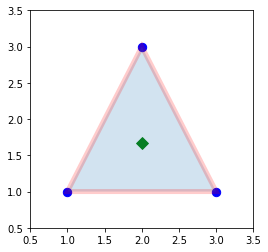

In [63]:
trishape = plt.Polygon(tri, edgecolor='r', alpha=0.2,
                       lw=5)
_, ax = plt.subplots(figsize=(4,4))
ax.add_patch(trishape)
ax.set_ylim([.5, 3.5])
ax.set_xlim([.5, 3.5])
ax.scatter(*centroid, color='g', marker='D', s=70)
ax.scatter(*tri.T, color='b', s=70);

<img src='EuclideanDistance.PNG'>

In [68]:
# the Euclidean distance of each point from the origin
# uses Pythagorean Theorem
np.sum(tri**2, axis=1) ** 0.5

array([1.41421356, 3.16227766, 3.60555128])

In [70]:
# the same as finding the Euclidean norms
np.linalg.norm(tri, axis=1)

array([1.41421356, 3.16227766, 3.60555128])

In [71]:
# instead of using the origin, you can also find the norm
# of each point relative to the triangle's centroid
np.linalg.norm(tri - centroid, axis=1)

array([1.20185043, 1.20185043, 1.33333333])

_Task_ : let's compute the Euclidean distance of each point from each centroid

In [82]:
X = np.repeat([[5,5],[10,10]],[5,5], axis=0)
X = X + np.random.randn(*X.shape)
centroids = np.array([[5,5],[10,10]])

In [80]:
X

array([[ 3.43876073,  5.47377479],
       [ 3.34667844,  5.24928257],
       [ 5.76987594,  5.51157738],
       [ 3.53552203,  5.53784687],
       [ 5.38130049,  6.31740667],
       [10.58265604,  9.74818683],
       [ 9.99732436,  7.93337861],
       [10.48760464, 10.60456797],
       [ 8.51503742, 10.06004839],
       [ 8.49492296, 11.01088537]])

In [87]:
centroids

array([[ 5,  5],
       [10, 10]])

_Task_:  Let's do some reshaping to enable broadcasting and answer the question  : "To which centroid does each point within X belong to?"


In [84]:
centroids[:, None]

array([[[ 5,  5]],

       [[10, 10]]])

In [85]:
centroids[:, None].shape

(2, 1, 2)

In [88]:
# combinatoric product of the rows
np.linalg.norm(X - centroids[:, None], axis=2).round(2)

array([[0.43, 0.96, 1.16, 1.32, 2.21, 6.66, 9.36, 6.62, 7.14, 6.8 ],
       [7.45, 6.37, 6.34, 6.37, 9.17, 0.73, 2.32, 0.54, 0.93, 0.28]])

In [95]:
# get the label of each closest centroid
# we find the minimum distance on the 0th axis from
# the array above
np.argmin(np.linalg.norm(X - centroids[:, None],
                         axis = 2), axis = 0)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [92]:
# placing the above into a function
def get_labels(X, centroids) -> np.ndarray:
    return np.argmin(np.linalg.norm(X - centroids[:, None],
                         axis = 2), axis = 0)
labels = get_labels(X, centroids)

Text(0.5, 1.0, 'One K-Means Iteration: Predicted Classes')

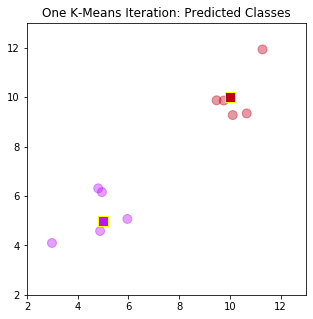

In [94]:
c1, c2 = ['#bc13fe', '#be0119']
llim, ulim  = np.trunc([X.min() * 0.9, X.max() * 1.1])
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*X.T, 
           c=np.where(labels, c2, c1), alpha=0.4, s=80)
ax.scatter(*centroids.T, c=[c1, c2], marker='s', s=95, 
           edgecolor='yellow')
ax.set_ylim([llim, ulim])
ax.set_xlim([llim, ulim])
ax.set_title('One K-Means Iteration: Predicted Classes')